<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        1. Import Libraries
    </p>
</div>


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings ('ignore')

2024-04-29 13:09:07.475834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 13:09:14.177305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package omw-1.4 to /home/rbabu3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rbabu3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rbabu3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/rbabu3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        2. Import Data
    </p>
</div>


In [3]:
df = pd.read_csv("text.csv")
print(df.head())

# Mapping emotions to sentiment labels
emotion_to_sentiment_3labels = {
    0: 0,  # sadness -> negative sentiment
    1: 1,  # joy/love -> neutral sentiment
    2: 1,
    3: 0,  # anger -> negative sentiment
    4: 2,  # fear/surprise -> positive sentiment
    5: 2   # fear/surprise -> positive sentiment
}

# Map the labels in the DataFrame
df['label'] = df['label'].map(emotion_to_sentiment_3labels)

# Display the updated DataFrame
print(df.head())

   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4
   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      2
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      2
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      2


In [4]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,2
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,2
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,2


In [5]:
df = df.drop(columns=['Unnamed: 0'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [7]:


# Modified null_count function for 3 labels
def null_count_3labels():
    return pd.DataFrame({
        'features': df.columns,
        'dtypes': df.dtypes.values,
        'NaN count': df.isnull().sum().values,
        'NaN percentage': df.isnull().sum().values / df.shape[0]
    }).style.background_gradient(cmap='turbo', low=0.1, high=0.01)

# Display the null count for 3 labels
null_count_3labels()

,features,dtypes,NaN count,NaN percentage
0,text,object,0,0.000000
1,label,int64,0,0.000000


In [8]:
df.duplicated().sum()

17229

In [9]:
df = df.drop_duplicates()

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        3.Feature Enginering
    </p>
</div>


In [10]:
df1 =df.copy()

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        Text
    </p>
</div>


In [11]:
unique_review = df1['text'].unique()
unique_review

array(['i just feel really helpless and heavy hearted',
       'ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing',
       'i gave up my internship with the dmrg and am feeling distraught',
       ...,
       'i feel very curious be why previous early dawn in the time here don t you seek his trouble',
       'i feel that becuase of the tyranical nature of the government in el salvador and the savage social conditions of the general people that the set of thought to run the shoe shop in miguel marmols testimoney was able to work',
       'i think that after i had spent some time investigating the surroundings and things i started to feel more curious about other people'],
      dtype=object)

In [12]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    # Remove stopwords and stem tokens
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Clean the text data in the 'text' column of DataFrame df
df1['cleaned_text'] = df1['text'].apply(clean_text)

# Print the DataFrame with cleaned text data
print(df1[['text', 'cleaned_text']])

                                                     text  \
0           i just feel really helpless and heavy hearted   
1       ive enjoyed being able to slouch about relax a...   
2       i gave up my internship with the dmrg and am f...   
3                              i dont know i feel so lost   
4       i am a kindergarten teacher and i am thoroughl...   
...                                                   ...   
416804  i feel like telling these horny devils to find...   
416805  i began to realize that when i was feeling agi...   
416806  i feel very curious be why previous early dawn...   
416807  i feel that becuase of the tyranical nature of...   
416808  i think that after i had spent some time inves...   

                                             cleaned_text  
0                        feel realli helpless heavi heart  
1       ive enjoy abl slouch relax unwind frankli need...  
2                    gave internship dmrg feel distraught  
3                          

In [13]:
df1['cleaned_text'] = df1['cleaned_text'].str.replace("http", "").str.replace("href", "").str.replace("img", "").str.replace("irc", "")


In [14]:
unique_review = df1['cleaned_text'].unique()
unique_review

array(['feel realli helpless heavi heart',
       'ive enjoy abl slouch relax unwind frankli need last week around end uni expo late start find feel bit listless never realli good thing',
       'gave internship dmrg feel distraught', ...,
       'feel curiou previou earli dawn time seek troubl',
       'feel becuas tyran natur govern el salvador savag social condit gener peopl set thought run shoe shop miguel marmol testimoney abl work',
       'think spent time investig surround thing start feel curiou peopl'],
      dtype=object)

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        Label
    </p>
</div>


In [15]:
df1.label.value_counts()

label
0    175529
1    165157
2     58894
Name: count, dtype: int64

In [16]:
mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}

df1['Emotion'] = df1['label'].map(mapping)


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       4.EDA
    </p>
</div>


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Emotion Distribution
    </p>
</div>


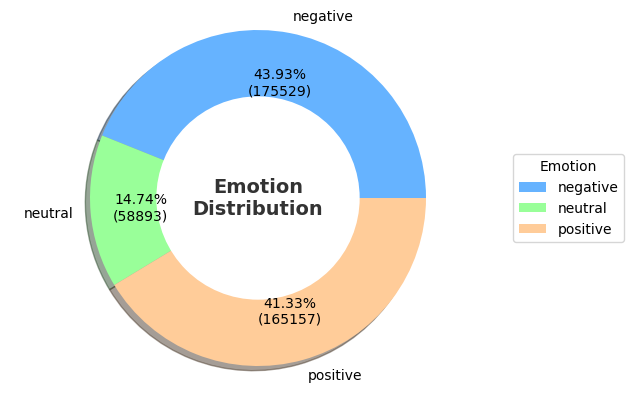

In [17]:
unique_emotion = df1['Emotion'].unique()

explode = [0] * len(unique_emotion)

emotion_counts = df1.groupby("Emotion").size()

colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0', '#ff9999']  # Menambahkan warna untuk 6 kategori

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=emotion_counts, 
    labels=emotion_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(emotion_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,  
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Emotion\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(emotion_counts.index, title="Emotion", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Bigrams
    </p>
</div>


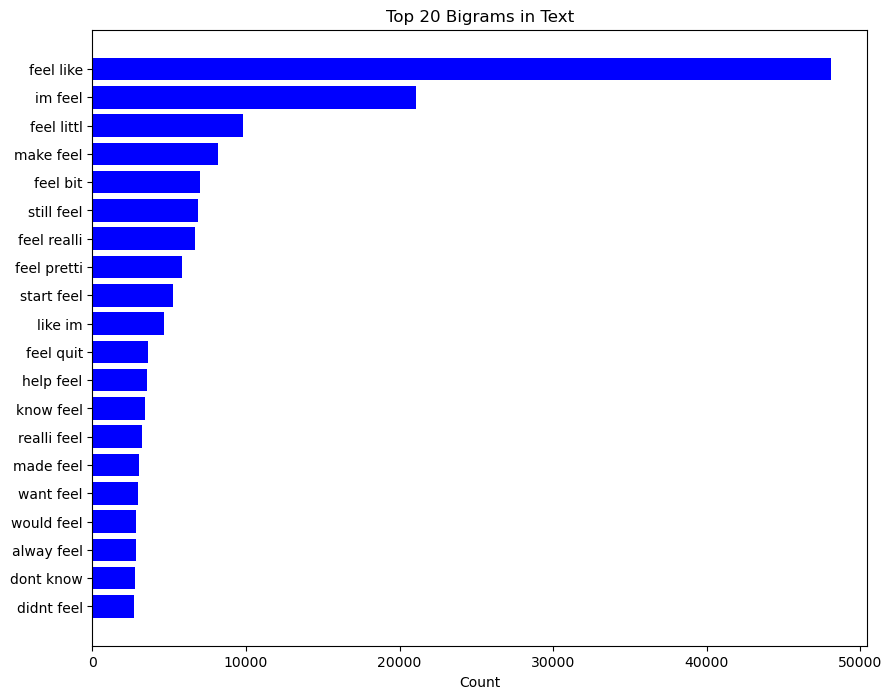

In [18]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_bigrams = get_top_n_bigram(df1['cleaned_text'], 20)

df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_bigrams['bigram'], df_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis()
plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Trigrams
    </p>
</div>


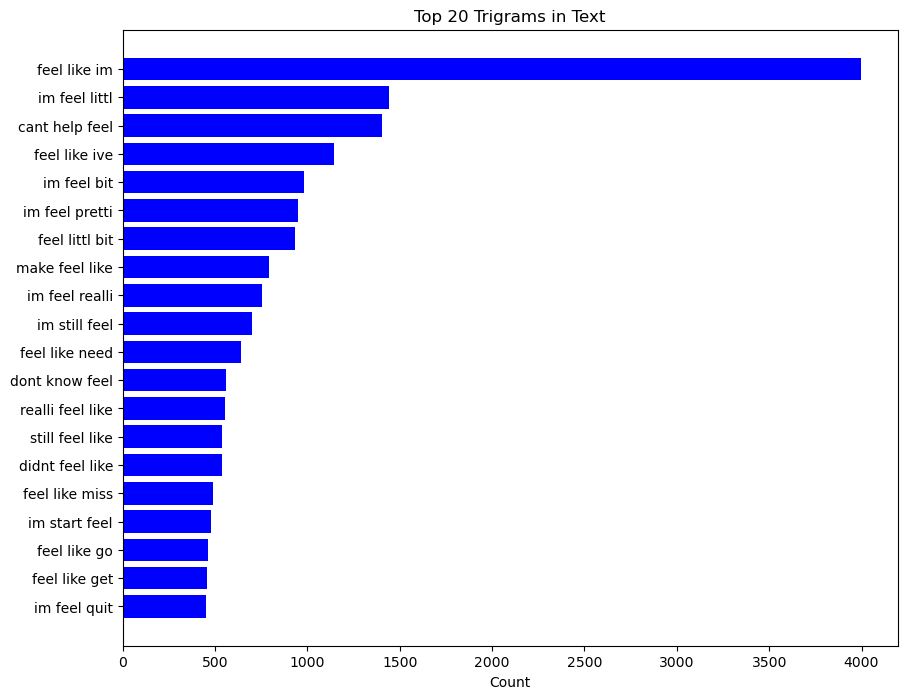

In [19]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_trigrams = get_top_n_trigram(df1['cleaned_text'], 20)

df_trigrams = pd.DataFrame(common_trigrams, columns=['trigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_trigrams['trigram'], df_trigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Trigrams in Text')
plt.gca().invert_yaxis()
plt.show()

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       WordCloud
    </p>
</div>


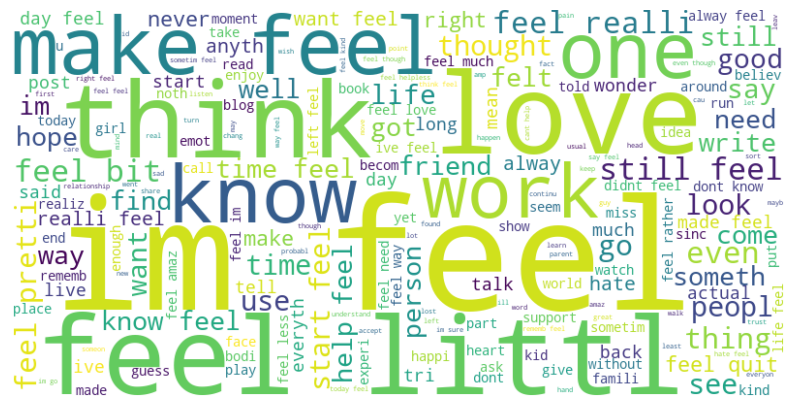

In [20]:
def make_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_words = ' '.join(df1['cleaned_text'])

make_word_cloud(all_words)


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       5.Modeling
    </p>
</div>


In [21]:
df2 = df1.copy()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df2['cleaned_text'], df2['label'], test_size=0.2, random_state=42)

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       CNN
    </p>
</div>


In [23]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)


In [24]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post')


In [25]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=50000, output_dim=16, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=6, activation='softmax'))


In [26]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


2024-04-29 13:11:16.712317: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=50, 
                             validation_data=(X_test_padded, y_test),
                             callbacks=[early_stopping])

Epoch 1/50
9990/9990 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - accuracy: 0.9067 - loss: 0.2165 - val_accuracy: 0.9654 - val_loss: 0.0813
Epoch 2/50
9990/9990 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.9698 - loss: 0.0653 - val_accuracy: 0.9662 - val_loss: 0.0742
Epoch 3/50
9990/9990 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.9747 - loss: 0.0525 - val_accuracy: 0.9671 - val_loss: 0.0711
Epoch 4/50
9990/9990 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9778 - loss: 0.0433 - val_accuracy: 0.9658 - val_loss: 0.0747
Epoch 5/50
9990/9990 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9798 - loss: 0.0381 - val_accuracy: 0.9634 - val_loss: 0.0850
Epoch 6/50
9990/9990 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9815 - loss: 0.0338 - val_accuracy: 0.9627 - val_loss: 0.0983


In [29]:
evaluation_result = cnn_model.evaluate(X_test_padded, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])


2498/2498 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9670 - loss: 0.0714
Test Loss: 0.07109277695417404
Test Accuracy: 0.967077910900116


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Confusion Matrix
    </p>
</div>


2498/2498 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


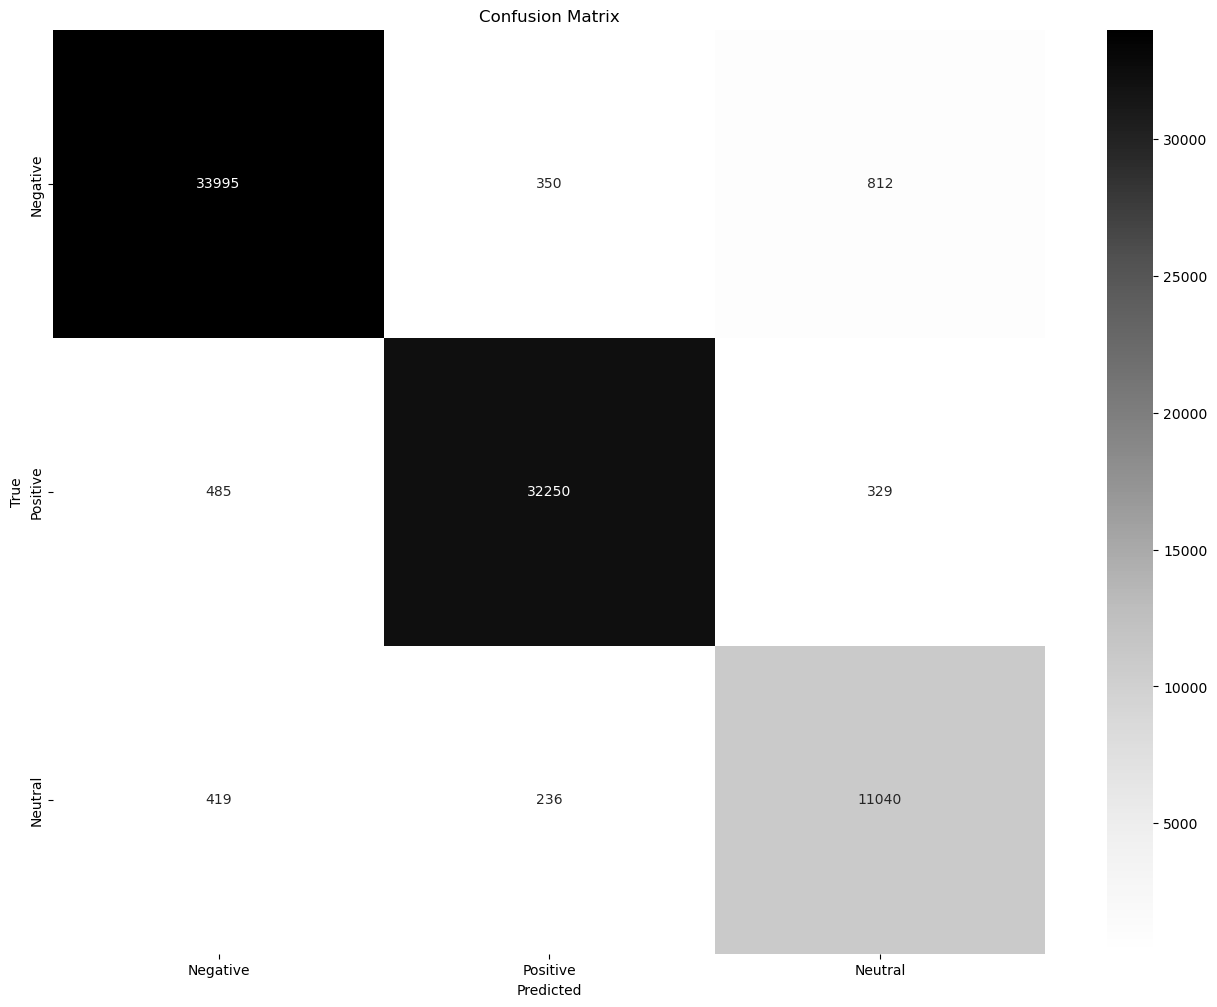

In [30]:
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

emotion_labels = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(16, 12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Classification Report
    </p>
</div>


In [31]:
target_names = ['Negative', 'Positive', 'Neutral']  
report = classification_report(y_test, y_pred, target_names=target_names)

print(report)

              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97     35157
    Positive       0.98      0.98      0.98     33064
     Neutral       0.91      0.94      0.92     11695

    accuracy                           0.97     79916
   macro avg       0.95      0.96      0.96     79916
weighted avg       0.97      0.97      0.97     79916



In [32]:
f1_scores = {'Negative': 0.97, 'Positive': 0.98, 'Neutral': 0.92}

threshold = 0.85  

chosen_emotion = max(f1_scores, key=lambda emotion: f1_scores[emotion] if f1_scores[emotion] >= threshold else 0)

print(f"The chosen emotion is: {chosen_emotion}")


The chosen emotion is: Positive


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Training and Validation
    </p>
</div>


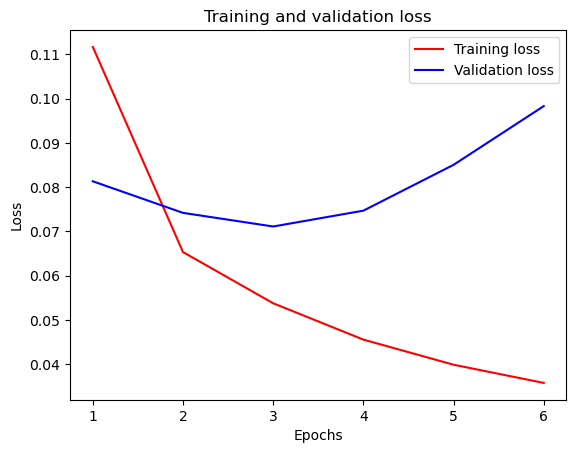

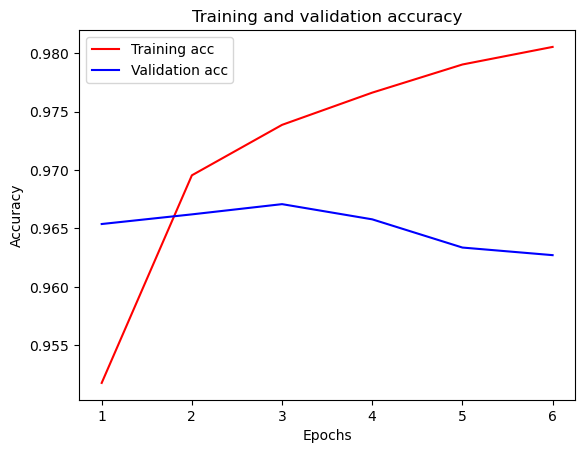

In [33]:
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
train_acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       ROC Curve
    </p>
</div>


2498/2498 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


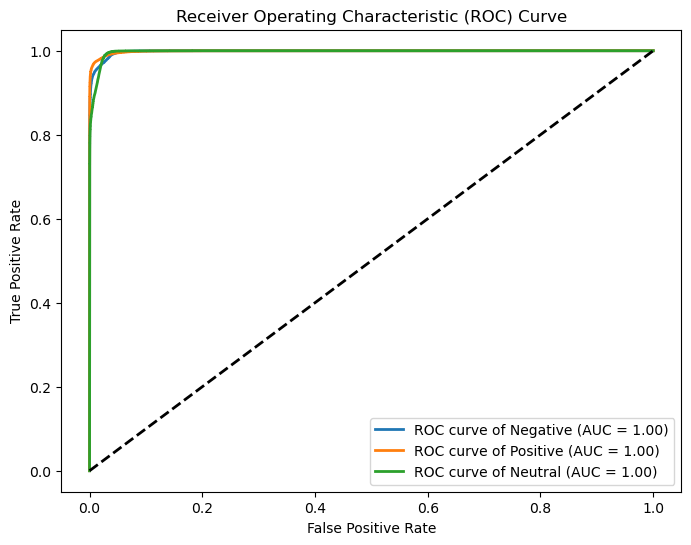

In [34]:
y_score = cnn_model.predict(X_test_padded)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3  
class_names = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class with distinct colors
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


                                                     text  \
0           i just feel really helpless and heavy hearted   
1       ive enjoyed being able to slouch about relax a...   
2       i gave up my internship with the dmrg and am f...   
3                              i dont know i feel so lost   
4       i am a kindergarten teacher and i am thoroughl...   
...                                                   ...   
416804  i feel like telling these horny devils to find...   
416805  i began to realize that when i was feeling agi...   
416806  i feel very curious be why previous early dawn...   
416807  i feel that becuase of the tyranical nature of...   
416808  i think that after i had spent some time inves...   

                                             cleaned_text  
0                        feel realli helpless heavi heart  
1       ive enjoy abl slouch relax unwind frankli need...  
2                    gave internship dmrg feel distraught  
3                          

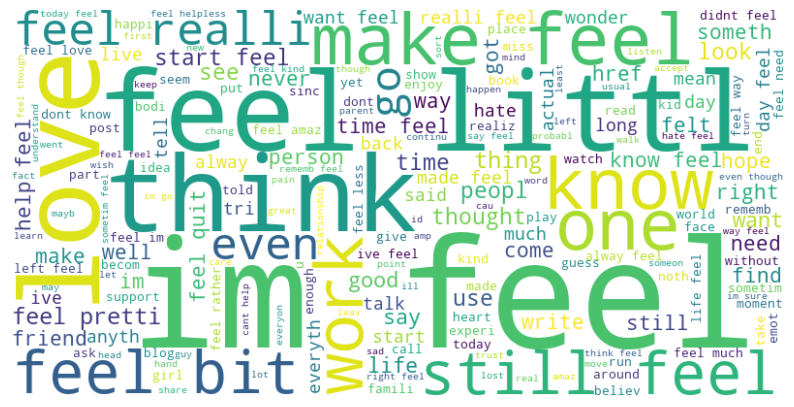

<class 'pandas.core.frame.DataFrame'>
Index: 399580 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text          399580 non-null  object
 1   label         399580 non-null  int64 
 2   cleaned_text  399580 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.2+ MB


In [35]:
df_new = pd.read_csv("testing.csv")

df_new = df_new.drop(columns=['Unnamed: 0'])

# Modified null_count function for 3 labels
def null_count_3labels():
    return pd.DataFrame({
        'features': df_new.columns,
        'dtypes': df_new.dtypes.values,
        'NaN count': df_new.isnull().sum().values,
        'NaN percentage': df_new.isnull().sum().values / df_new.shape[0]
    }).style.background_gradient(cmap='turbo', low=0.1, high=0.01)

# Display the null count for 3 labels
null_count_3labels()

df_new.duplicated().sum()

df_new = df.drop_duplicates()

# Clean the text data in the 'text' column of DataFrame df_new
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    # Remove stopwords and stem tokens
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Apply the clean_text function to the 'text' column
df_new['cleaned_text'] = df_new['text'].apply(clean_text)

# Display the DataFrame with cleaned text data
print(df_new[['text', 'cleaned_text']])

all_words = ' '.join(df_new['cleaned_text'])
make_word_cloud(all_words)

# Print the cleaned DataFrame information
df_new.info()

12487/12487 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


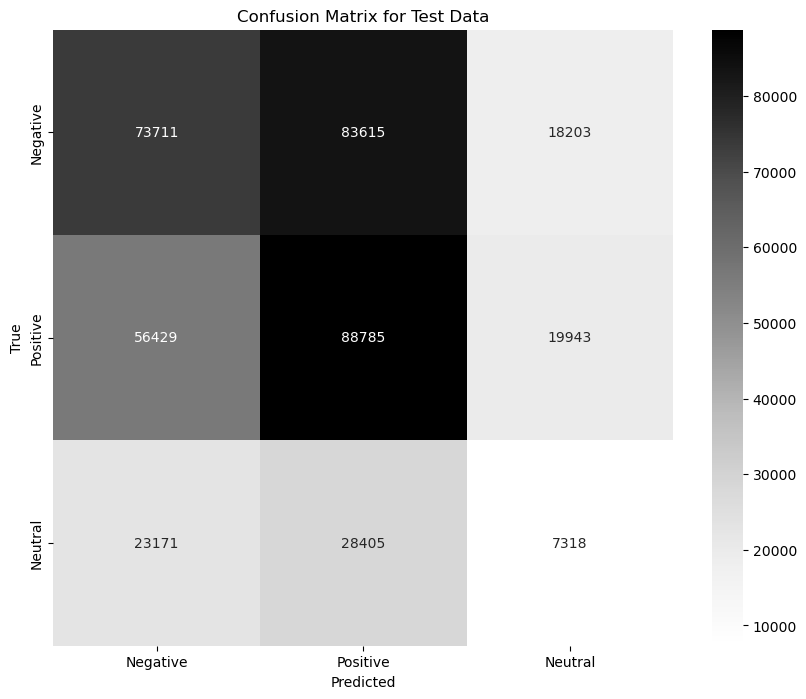

              precision    recall  f1-score   support

    Negative       0.48      0.42      0.45    175529
    Positive       0.44      0.54      0.49    165157
     Neutral       0.16      0.12      0.14     58894

    accuracy                           0.42    399580
   macro avg       0.36      0.36      0.36    399580
weighted avg       0.42      0.42      0.42    399580



In [36]:
# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(df_new['cleaned_text'])

X_test_padded = pad_sequences(tokenizer.texts_to_sequences(df_new['cleaned_text']), maxlen=100, padding='post')

# Make predictions
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)

# Generate confusion matrix
conf_mat = confusion_matrix(df_new['label'], y_pred)

emotion_labels = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report
target_names = ['Negative', 'Positive', 'Neutral']  
report = classification_report(df_new['label'], y_pred, target_names=target_names)

print(report)